# This notebook is an implementation of the Newton's  law of gravitation.

# A sequential and a vectorize solver are implemented.

# An illustration of 3-body system chaos is given.


## Imports

In [1]:
import numpy as np
from timeit import default_timer as timer
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32
from matplotlib import pyplot as plt ; from matplotlib import colors
import itertools
import random
from datetime import timedelta
import dateutil
import math
import sys
import copy

## Helper classes

In [2]:
class Vect3D:
    def __init__(self):
        ''
    def diff(self, vect0, vect1):
        return (vect1-vect0)    
    def rotate_z(self, vect_center, vect_point, theta):
        vect = vect_point-vect_center
        a = math.cos(theta)
        b = math.sin(theta)
        rot = np.array([a*vect[0] - b*vect[1], b*vect[0]+a*vect[1],0])
        return vect_center + rot

class TimeHelper:
    def __init__(self):
        ''
    def formatTime(self, time_days):
        if (time_days<1):
            return '%d hours'%round(time_days*60.)
        if (time_days<366):
            return '%d days'%round(time_days)
        if (365<time_days<=3650):
            return '%d years and %d days'%(int(time_days/365.),round(time_days%365))
        if (3650<time_days):
            return '%d years'%(int(time_days/365.))

## Particle and particles container 

A Particle3D is a ponctual body defined by its name, mass, position and velocities

In [3]:
class Particle3D:
    def __init__(self, mass, x, y, z, u_x, u_y, u_z, name = ''):
        self.name  = name
        self.mass  = mass
        self.x = x ; self.y = y ; self.z = z    
        self.u_x = u_x ; self.u_y = u_y ; self.u_z = u_z  
    def pos(self):
        return self.x, self.y, self.z
    def vel(self):
        return self.u_x, self.u_y, self.u_z
    def randomize(self, ratio):
        """ Randomize position of particle"""
        self.x = self.x * (1+random.choice([-1, +1.])*ratio)
        self.y = self.y * (1+random.choice([-1, +1.])*ratio)
        self.z = self.z * (1+random.choice([-1, +1.])*ratio)  

In [4]:
class Particles3D:
    def __init__(self, particles):
        
        self.particles=particles 
        self.N = len(particles)
        self.mass = sum([part.mass for part in particles]) # Compute total mass
        self.ci_average_sq_vel = sum([part.u_x**2+part.u_y**2+part.u_z**2 for part in particles])/self.N
        self.ci_max_sq_vel = max([part.u_x**2+part.u_y**2+part.u_z**2 for part in particles])/self.N        
     
    def compute_mass_center(self):
        x, y, z = 0.,0.,0.        
        for part in self.particles:
            x+= part.x*part.mass 
            y+= part.y*part.mass
            z+= part.z*part.mass
        x*=1./self.mass
        y*=1./self.mass
        z*=1./self.mass
        return (x, y, z)            
    
    def get_X_Y_Z(self):        
        return np.asarray([part.x for part in self.particles]), \
                np.asarray([part.y for part in self.particles]),\
                np.asarray([part.z for part in self.particles])  
    
    def particles2arrayPos(self):
        a_pos = np.zeros((len(self.particles),3), dtype = np.float64)
        for i,part in enumerate(self.particles):
            a_pos[i,:] = [part.x, part.y, part.z]
        return a_pos
    
    def particles2arrayVel(self):
        a_vel = np.zeros((len(self.particles),3), dtype = np.float64)
        for i,part in enumerate(self.particles):
            a_vel[i,:] = [part.u_x, part.u_y, part.u_z]
        return a_vel
    
    def get_mass(self):
        mass = np.zeros(self.N, dtype= np.float64)
        for i, part in enumerate(self.particles):
            mass[i] = part.mass            
        return mass

## Initial Conditions builder 

In [5]:
%run Horizon.py
class IC_Builder:
    """
    Initial conditions builder.
    Uses the script horizon.py to read data from JPL horizons website.
    """
    def __init__(self, G):
        '' 
        self.G=G
        self.particles = []        
        self.horizon = Horizon()
      
    def add_random(self, N, mass = [10000.,20000.] , x = [-0.5,0.5], y = [-0.5,0.5] , z = [0.,0.] ,dx = [-0.01,0.01], dy =[-0.01,0.01], dz =[0.,0.] ):
        particles = []
        for i in range(N):
            particles.append(Particle3D(random.uniform(mass[0], mass[1]), 
                                          random.uniform(x[0], x[1]),
                                          random.uniform(y[0], y[1]),
                                          random.uniform(z[0], z[1]),  
                                          random.uniform(dx[0], dx[1]),
                                          random.uniform(dy[0], dy[1]),
                                          random.uniform(dz[0], dz[1]) ))
        self.particles =self.particles+ particles 
    
    def add_solar_system_id(self, str_planet, date= '1980-05-25', date_end= '1980-05-26', name = ''):
        particles = []
        self.horizon.call_horizon(id = str_planet, 
                             start_time=date, 
                             stop_time=date_end, 
                             step_size ='1d')    
        
        particles.append(Particle3D(self.horizon.get_mass(str(str_planet)), 
                                      self.horizon.data[0][2], #x
                                      self.horizon.data[0][3], #y
                                      self.horizon.data[0][4],
                                      self.horizon.data[0][5], #vx
                                      self.horizon.data[0][6],
                                      self.horizon.data[0][7],
                                      name = str(name) ))
        self.particles = self.particles + particles         
    
    def add_rotating(self , N,  mass = [1.,1.] ,radius = [1.,1.], grav_factor= 1. ):  
       
            vect3D = Vect3D()
            masses = [random.uniform(mass[0], mass[1]) for i in range(N)]            
            total_mass= sum(masses)
            mass_other_particles = sum([part.mass for part in self.particles])
            total_mass+=mass_other_particles            
            theta = np.linspace(0.,2*math.pi, N, endpoint = False)
            for i in range(N):           
                r   = random.uniform(radius[0], radius[1])      
                dy = math.sqrt(self.G*(total_mass)/r)
                dx = -grav_factor*dy
                dy = (1-grav_factor)*dy
                
                # Rotate velocity (theta_rad to stay perpendicular to position, delta_orbit to induce randomness)
                vel = np.array([0., dy, 0.])
                pos = np.array([r, 0., 0.])                
                center = np.array([0., 0., 0.])
                vel = vect3D.rotate_z(center, vel, theta[i])
                pos = vect3D.rotate_z(center, pos , theta[i])
                self.particles.append(Particle3D(masses[i], pos[0], pos[1], pos[2], vel[0], vel[1], vel[2]))
       

## SOLVERS

### Solvers are classes that solves the newton's second law equations for a given set of particles.


The force of a particle j on a particle i is : $\vec{F_{ij}} = \frac{m_{i}.m_{j}}{r_{ij}^{2}}.\vec{e_{ij}}$

If particle i and j are respectively at position $\vec{OI}$ and $\vec{OJ}$, we can rewrite the previous equation as :

$\vec{F_{ij}} = \frac{m_{i}.m_{j}}{r_{ij}^{3}}.(\vec{OJ}-\vec{OI})$

That we rewrite as :

$\vec{F_{ij}} = m_{i}.m_{j}.\vec{a_{ij}}$

With :

$\vec{a_{ij}}=\frac{1}{r_{ij}^{3}}.(\vec{OJ}-\vec{OI})$

Abstract classes for solvers

In [6]:
# Abstract solver with helper functions
class Solver():    
    def  __init__(self,  particles3D, G, dt, name=''):
        self.name = name 
        self.dt = dt  # Time step
        self.G  = G  # Gravity constant
        self.a_pos = particles3D.particles2arrayPos() # Set particles positions to array a_pos
        self.a_vel = particles3D.particles2arrayVel() # Set particles velocities to array a_pos
        self.N = np.shape(self.a_pos)[0]  # Number of particles
  
        self.aij= np.zeros(( int((self.N-1)*self.N/2), 3 ), dtype= np.float64) # Distance between particles
        self.mass_gdt = particles3D.get_mass()*self.G*self.dt   # Compute once and for all M.G.dt     
        self.du = np.zeros(( self.N, 3 ))  # Velocity differenial
        
        self.compute_total_mass()
        self.compute_mass_center()
        
    def compute_total_mass(self):
        self.tot_mass = np.sum(self.mass_gdt)
        
    def compute_mass_center(self):
        self.mass_center = np.zeros(3)          
        for i in range(self.N):
            self.mass_center += self.mass_gdt[i]*self.a_pos[i,:]
        self.mass_center = self.mass_center / self.tot_mass
    
    def get_mass_center(self):
        return self.mass_center

A sequential solver

In [7]:
# Our first solver
class SequentialSolver(Solver):
    def  __init__(self,  particles3D, G, dt, name='SequentialSolver'):          
        Solver.__init__(self, particles3D, G, dt, name ) 
    
    def compute_aij(self):
        """ 
        As aij = -aji, we only need to compute aij for j>i.
        """
        compteur = 0
        for i in range(self.N-1): 
            for j in range(i+1, self.N):  
                diff = self.a_pos[j,:]-self.a_pos[i,:]
                aij=1./(diff[0]**2+diff[1]**2+diff[2]**2)**1.5   
                self.aij[compteur]=aij*diff                
                compteur+=1   
   
    def solve(self):
        """
        Solve Newton's second law for all particles.
        """
        self.compute_aij()
        self.du[:,:] = 0
        compteur = 0         
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.du[i]+=self.aij[compteur]*self.mass_gdt[j]               
                self.du[j]-=self.aij[compteur]*self.mass_gdt[i]
                compteur+=1            
        
        self.a_vel += self.du
        self.a_pos += self.a_vel*self.dt    


A vectorize solver using Numba library

In [8]:
@guvectorize(['void(float64[:], float64[:], float64[:])'], '(n),(n)->(n)')
def aij_vect(vect0, vect1, res):
    """
    Compute aij between vect0 and vect1 and set the result in res. Check numba's manual for more informations.
    """
    temp = 0.
    diff = vect1-vect0
    for k in range(3):
        temp +=(diff[k])**2
    for k in range(3):
        res[k]=1./(temp**(1.5))*diff[k]   

In [9]:
class VectorizeSolver(Solver):
    def __init__(self,  particles3D, G, dt,name='VectorizeSolver'):
        ''
        Solver.__init__(self, particles3D, G, dt, name )   
        self.vect0 = np.zeros(( int((self.N-1)*self.N/2), 3 ), dtype= np.float64)
        self.vect1 = np.zeros(( int((self.N-1)*self.N/2), 3 ), dtype= np.float64)   
        
    def compute_aij(self):
        compteur = 0
        # Prepare vect0 and vect1
        for i in range(self.N): 
            self.vect0[compteur:compteur +self.N-1-i,:] = np.tile(self.a_pos[i,:],(self.N-1-i,1))
            self.vect1[compteur:compteur +self.N-1-i,:] = self.a_pos[i+1:,:]
            compteur += self.N-1-i
        self.aij = aij_vect(self.vect0, self.vect1)
   
    def solve(self):
        self.compute_aij()
        self.du[:,:] = 0
        compteur = 0         
        for i in range(self.N):
            for j in range(i+1, self.N):
                self.du[i]+=self.aij[compteur]*self.mass_gdt[j]               
                self.du[j]-=self.aij[compteur]*self.mass_gdt[i]
                compteur+=1            
                  
        self.a_vel += self.du
        self.a_pos += self.a_vel*self.dt   

# Game Engine to manage computation and rendering

In [10]:
class GameEngine:
    def __init__(self, solver_list, dt, starting_date, display_scale=1.):
        ''
        self.dt=dt
        self.time_helper = TimeHelper()
        self.display_scale = display_scale
        self.pos = 0
        self.solver_list=solver_list
        self.date=starting_date
        
    def game_logic(self):
        for solver in self.solver_list:
            solver.solve()
    
    def draw2D(self):   
        
        self.ax.set_title('Simulation time :%s J'%str(self.date))
      
        for i, solver in enumerate(self.solver_list):           
            self.graph_points[i].set_xdata(solver.a_pos[:,0])
            self.graph_points[i].set_ydata(solver.a_pos[:,1])
        if(self.track_mass_center):
            self.ax.set_xlim(-self.display_scale + self.solver_list[0].get_mass_center()[0], self.display_scale+ self.solver_list[0].get_mass_center()[0])
            self.ax.set_ylim(-self.display_scale+ self.solver_list[0].get_mass_center()[1], self.display_scale+ self.solver_list[0].get_mass_center()[1])
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()          
    
    def set_graph2D(self):
  
        self.fig = plt.figure(figsize=(8, 5), dpi=100)
        self.ax = self.fig.add_subplot(111)  
        self.ax.set_xlim(-self.display_scale + self.solver_list[0].get_mass_center()[0], self.display_scale+ self.solver_list[0].get_mass_center()[0])
        self.ax.set_ylim(-self.display_scale+ self.solver_list[0].get_mass_center()[1], self.display_scale+ self.solver_list[0].get_mass_center()[1])
        self.ax.set_ylabel('Distance (Sun-Earth unit)')
        self.ax.set_title('Simulation time :')
        self.ax.grid()
        
        self.graph_points = []
        self.graph_velocities = []
        self.annotations = []
        box = self.ax.get_position()
        self.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        marker = itertools.cycle(('o', '+', '*')) 
        for solver in self.solver_list:
            current_marker = next(marker)           
            self.graph_points.append(self.ax.plot(solver.a_pos[:,0], solver.a_pos[:,1],  linestyle = 'None',marker = current_marker, label=solver.name)[0])  
        self.ax.set_aspect('equal')
        self.ax.legend(loc=2)        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
    def init_game(self, is_graph= True): 
        if(is_graph):  
            self.set_graph2D()   
    
    def text(self, text):        
        sys.stdout.write('\r')
        sys.stdout.flush()
        sys.stdout.write(text)        
    
    def run_computation(self, nb_iterations):  
        
        self.init_game(is_graph=False)
        for i in range(nb_iterations): 
            self.date +=  timedelta(hours=24.*self.dt)
            self.game_logic()             
            
    def game_loop(self, FPS = 30, speedup=1, track_mass_center = False):
       
        self.speedup=speedup
        self.track_mass_center=track_mass_center        
        self.init_game()  
        lastFrameTime=time.time()
        self.simulation_time = 0.
        
        while True:                  
            currentTime = time.time()     
            sleepTime = 1./FPS - (currentTime - lastFrameTime)
            
            if sleepTime > 0:  
                time.sleep(sleepTime) # Wait for dt to be close to 1/FPS            
            # dt is the time delta in seconds (float).
            currentTime = time.time()
            dt = currentTime - lastFrameTime
            lastFrameTime = currentTime
            self.fps=round(1./dt)
            
            for i in range(speedup):
                self.game_logic()
                self.simulation_time+=self.dt
                self.date +=  timedelta(hours=24.*self.dt)
            if(track_mass_center):
                self.solver_list[0].compute_mass_center()
  
            self.draw2D()

# Let's build the Initial Conditions

In [11]:
ic = IC_Builder(0.)
ic.add_solar_system_id(10, name='Sun')
ic.add_solar_system_id(199, name='Mercury')
ic.add_solar_system_id(499, name='Mars')
ic.add_solar_system_id(299, name='Venus')
ic.add_solar_system_id(599, name='Jupiter')
ic.add_solar_system_id(699, name='Saturn')
ic.add_solar_system_id(799, name='Uranus')
ic.add_solar_system_id(899, name='Neptune')
ic.add_solar_system_id(999, name='Pluto')
ic.add_solar_system_id(399, name='Earth')
ic.add_solar_system_id(301, name='Moon')


## Here we go, let's time the solvers...

In [13]:
# Universal gravity constant in unit : (AU.D)^3 / Mterre / Jours^2
G=6.674*1e-11*5.9722*1e24*(3600.*24.)**2/((149.6*1e9)**3)
# Computational time step
dt = 1/24.
# Set the starting date to display
starting_date = dateutil.parser.parse('1605-01-01 00:00')
# Create a vectorize solver
solver_vect  = VectorizeSolver(particles3D=Particles3D(ic.particles), G=G, dt=dt)
# Create the game engine
gameEngine  =GameEngine([solver_vect], display_scale = 3, dt=dt, starting_date=starting_date)
# Let's time 100 iterations
%timeit  gameEngine.run_computation(100)

38.5 ms ± 613 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
# Create a vectorize solver
solver_seq  = SequentialSolver(particles3D=Particles3D(ic.particles), G=G, dt=dt)
# Create the game engine
gameEngine  = GameEngine([solver_seq], display_scale = 3, dt=dt, starting_date=starting_date)
# Let's time 100 iterations
%timeit  gameEngine.run_computation(100)

52.8 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## ... and display some results (guess where earth is !)

<IPython.core.display.Javascript object>


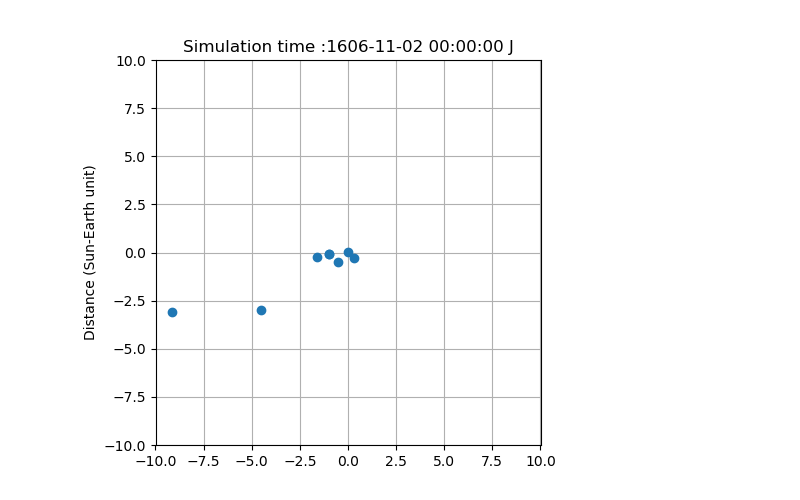

KeyboardInterrupt: 

In [16]:
%matplotlib notebook  
solver_vect  = VectorizeSolver(particles3D=Particles3D(ic.particles), G=G, dt=dt, name='')
gameEngine  =GameEngine([solver_vect], display_scale = 10, dt=dt, starting_date=starting_date)
gameEngine.game_loop(FPS=30, speedup=24*5, track_mass_center = True)

## Let's compare the solver performance for different numbers of particles


Parametric studies on numbers of bodies (from 1 to 1000) for the sequential and vectorize solver

In [22]:
# Universal gravity constant in unit : (AU.D)^3 / Mterre / Jours^2
G=6.674*1e-11*5.9722*1e24*(3600.*24.)**2/((149.6*1e9)**3)
# Time step : 1hour
dt = 1/24.
# Let's compute 5 iterations
iteration = 5

def compare():
    # Ns : number of particles
    # Nb_compu : number of iterations 
    Ns = np.array([1,10,50,100,500, 1000])
    
    # Variables to store results
    time_seq = np.zeros(Ns.size)
    time_vect = np.zeros(Ns.size)
    
    for i in range(Ns.size):        
        N = Ns[i]
        ic = IC_Builder(0.)
        ic.add_solar_system_id(10, name='Sun')
        ic.add_rotating(N, mass = [1.,1.], radius = [1.,1.5])
        solver_seq  = SequentialSolver(particles3D=Particles3D(ic.particles), G=G, dt=dt)
        solver_vect  = VectorizeSolver(particles3D=Particles3D(ic.particles), G=G, dt=dt)  
        
        # Run and time sequential solver
        gameEngine  = GameEngine([solver_seq], dt=dt,starting_date=starting_date)
        start_time = time.time()
        gameEngine.run_computation(iteration)
        time_seq[i] = (time.time()-start_time)/(iteration)  
        
        # Run and time vectorize solver
        gameEngine  = GameEngine([solver_vect],dt=dt,starting_date=starting_date)
        start_time = time.time()
        gameEngine.run_computation(iteration)
        time_vect[i] = (time.time()-start_time)/(iteration)
        
    return Ns, time_seq,time_vect

Ns, time_seq, time_vect = compare()   


Let's plot the results and show that the vectorize solver is the fastest

<IPython.core.display.Javascript object>


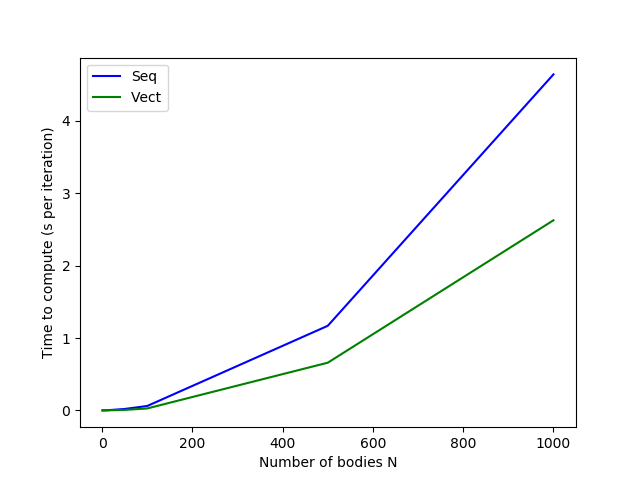

In [23]:
%matplotlib notebook  
plt.plot(Ns, time_seq, 'b-', label = 'Seq')
plt.plot(Ns, time_vect, 'g-', label = 'Vect')
plt.legend()
plt.xlabel('Number of bodies N') ; plt.ylabel('Time to compute (s per iteration)')
plt.show()         

# Illustration of 3-body chaos

Let's build 4 identical 3-body system : ci1, ci2, ci3, ci4

In [25]:
G=6.674*1e-11*5.9722*1e24*(3600.*24.)**2/((149.6*1e9)**3)
ic1 = IC_Builder(G)
ic1.add_rotating(3, mass = [10000,15000], radius = [0.4,0.4], grav_factor = 0.65)
ic2 = IC_Builder(G)
ic2.particles = copy.deepcopy(ic1.particles)
ic3 = IC_Builder(G)
ic3.particles = copy.deepcopy(ic1.particles)
ic4 = IC_Builder(G)
ic4.particles = copy.deepcopy(ic1.particles)

Now, we move just a little bit the position of ci2 (at +- 1e-3)

In [27]:
r = 1e-3
for i, part in enumerate(ic2.particles):
        part.randomize(r)

Same with ci3 at +-1e-6 and ci4 at +-1e-9

In [28]:
r = 1e-6
for i, part in enumerate(ic3.particles):
        part.randomize(r)
r = 1e-9
for i, part in enumerate(ic4.particles):
        part.randomize(r)

Let's create solvers for each 3-body system. Then we run them and display the results on the same graph.

We  observe that the small differences in the initial conditions lead to huge differences in the trajectories of our 4 3-body systems.

<IPython.core.display.Javascript object>


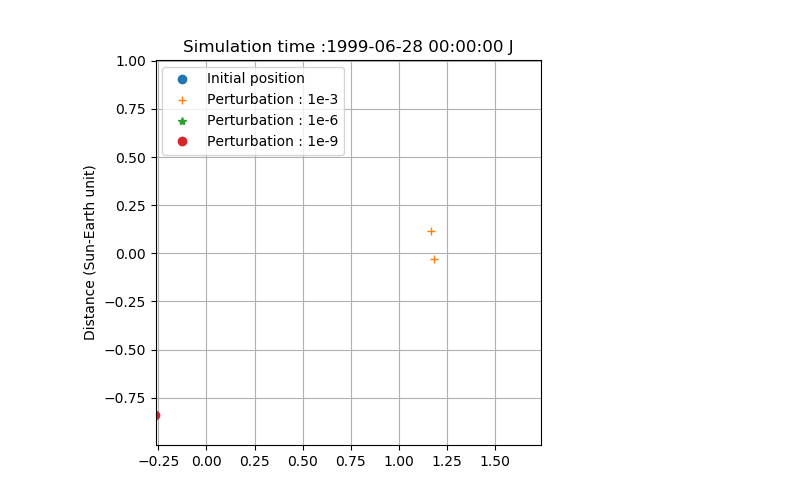

KeyboardInterrupt: 

In [30]:
%matplotlib notebook  
# Universal gravity constant in unit : (AU.D)^3 / Mterre / Jours^2
G=6.674*1e-11*5.9722*1e24*(3600.*24.)**2/((149.6*1e9)**3)
# Computational time step
dt = 1./(24.)
starting_date = dateutil.parser.parse('1990-01-01 00:00')
solver_vect1  = VectorizeSolver(particles3D=Particles3D(ic1.particles), G=G, dt=dt, name = 'Initial position')
solver_vect2  = VectorizeSolver(particles3D=Particles3D(ic2.particles), G=G, dt=dt, name = 'Perturbation : 1e-3')
solver_vect3  = VectorizeSolver(particles3D=Particles3D(ic3.particles), G=G, dt=dt, name = 'Perturbation : 1e-6')
solver_vect4  = VectorizeSolver(particles3D=Particles3D(ic4.particles), G=G, dt=dt, name = 'Perturbation : 1e-9')

gameEngine  = GameEngine([solver_vect1, solver_vect2, solver_vect3, solver_vect4], display_scale = 1, dt=dt, starting_date=starting_date)
gameEngine.game_loop(FPS=30, speedup=24*3, track_mass_center = True)